<a href="https://colab.research.google.com/github/elmox0818/ai_news/blob/master/%E6%A0%AA%E4%BE%A1%E4%BA%88%E6%83%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 機械学習であつまれどうぶつの森の株価を予想してみよう！

前提知識
- あつまれどうぶつの森って？
> 任天堂から今年発売されたゲームです。コロナの影響でおうち時間が増えたため現在世界中で人気です。
- どういうゲーム？
> 無人島で虫や魚を捕まえて売ってお金を稼いだり、家を大きくしたり、株を揃えたりといった生活を楽しむゲームです。
- 株がゲームの中にあるの？
> ゲームの中の時間は現実世界とリンクしていて毎週日曜日の午前中にとあるキャラクターから株を購入することができます。その後一週間かけて株の売値が変動し、買値より高いタイミングで売ると利益を出すことができます。

今回やりたいこと
- 機械学習・AIの技術で株価の変動を予測する
    - 一週間を通してどういう変化をするのか
    - いつ売れば利益が出るのか

## データの確認

In [3]:
# おまじない
%matplotlib inline

# ライブラリのインポート
import pandas as pd
import numpy as np
import seaborn as sns

# データの読み込み、表示
df = pd.read_csv("kabu_data.csv")
df

,日曜AM,日曜PM,月曜AM,月曜PM,火曜AM,火曜PM,水曜AM,水曜PM,木曜AM,木曜PM,金曜AM,金曜PM,土曜AM,土曜PM,変動タイプ
0,0,0,122,129,65,59,50,145,73,65,120,113,104,100,波型
1,0,0,82,108,187,576,290,259,44,40,59,75,45,72,跳ね大型
2,0,0,93,103,123,113,85,55,47,109,58,51,46,103,波型
3,0,0,76,71,67,62,58,115,102,107,155,150,54,50,跳ね小型
4,0,0,40,35,31,98,131,124,142,138,28,23,19,15,跳ね小型
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5209,0,0,73,63,132,69,64,57,147,132,116,147,112,108,波型
5210,0,0,117,119,96,120,98,47,43,117,100,66,57,49,波型
5211,0,0,92,111,207,569,441,550,80,55,80,98,93,51,跳ね大型
5212,0,0,51,46,122,109,135,92,109,130,57,48,40,96,波型


## 株価変動パターンの解説

このゲームでは株価の変動パターンが4種類に分かれます。

1. 波型
> 株価が上下に変動
2. 減少型
> 一週間下がり続ける
3. 跳ね小型
> 最大で買った値段の2倍程度まで上昇
4. 跳ね大型
> 最大で買った値段の6倍程度まで上昇

日曜日はプログラムでは0に設定されていて、月曜日　〜　土曜日にかけてそれぞれのパターンの決まったロジックで価格が決定されます。

## データの整形

In [0]:
# プログラムに読み込ませるために数値に置き換えます
df = df.replace("波型", 0)
df = df.replace("減少型", 1)
df = df.replace("跳ね小型", 2)
df = df.replace("跳ね大型", 3)

# あとで参照するために辞書を作成しておきます
show_type = [
             {0: "波型"},
             {1: "減少型"},
             {2: "跳ね小型"},
             {3: "跳ね大型"},
]

In [7]:
df.head()

,日曜AM,日曜PM,月曜AM,月曜PM,火曜AM,火曜PM,水曜AM,水曜PM,木曜AM,木曜PM,金曜AM,金曜PM,土曜AM,土曜PM,変動タイプ
0,0,0,122,129,65,59,50,145,73,65,120,113,104,100,0
1,0,0,82,108,187,576,290,259,44,40,59,75,45,72,3
2,0,0,93,103,123,113,85,55,47,109,58,51,46,103,0
3,0,0,76,71,67,62,58,115,102,107,155,150,54,50,2
4,0,0,40,35,31,98,131,124,142,138,28,23,19,15,2


In [0]:
# 日曜日は必ず0で邪魔になりそうなので省きます
df = df.iloc[:, 2:]

In [9]:
df.head()

,月曜AM,月曜PM,火曜AM,火曜PM,水曜AM,水曜PM,木曜AM,木曜PM,金曜AM,金曜PM,土曜AM,土曜PM,変動タイプ
0,122,129,65,59,50,145,73,65,120,113,104,100,0
1,82,108,187,576,290,259,44,40,59,75,45,72,3
2,93,103,123,113,85,55,47,109,58,51,46,103,0
3,76,71,67,62,58,115,102,107,155,150,54,50,2
4,40,35,31,98,131,124,142,138,28,23,19,15,2


## データの分割

まずは月曜〜土曜の株価からどの変動タイプかを判定するモデルを作成しましょう。月曜から土曜日のデータと答えとなる変動タイプとに分割します。

In [10]:
X = df.iloc[:, :-1]
X.head()

,月曜AM,月曜PM,火曜AM,火曜PM,水曜AM,水曜PM,木曜AM,木曜PM,金曜AM,金曜PM,土曜AM,土曜PM
0,122,129,65,59,50,145,73,65,120,113,104,100
1,82,108,187,576,290,259,44,40,59,75,45,72
2,93,103,123,113,85,55,47,109,58,51,46,103
3,76,71,67,62,58,115,102,107,155,150,54,50
4,40,35,31,98,131,124,142,138,28,23,19,15


In [11]:
y = df.iloc[:, -1]
y.head()

0    0
1    3
2    0
3    2
4    2
Name: 変動タイプ, dtype: int64

## 教師用データとテスト用データの作成

機械学習では「教師用データ」と「テスト用データ」とに分割します。

> 英単語帳を一冊買って、その内容を全て覚えたならば英語が完璧だと言えるでしょうか？その単語帳に載っていない単語に対しても意味を理解したり推測できて初めて英語ができると言えます。

教師用データで学習を行い、テスト用データでその精度を測ります。

In [0]:
# ライブラリを読み込み
from sklearn.model_selection import train_test_split

# データを分割します。テスト用には40%を割り当てます
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

## 機械学習スタート！

In [13]:
# ライブラリの読み込み
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

## 果たして精度は・・・

In [14]:
clf.score(X_test, y_test)

0.9908916586768935

## 99%の正答率を得ることができました！

つまり月曜日〜土曜日の全ての株価があればほぼ確実に変動タイプが判定できるということです。

では週のどのタイミングで高い判定率を得ることができるでしょうか？

In [0]:
def show_accuracy(dataframe, data_number=11):
    X = dataframe.iloc[:, :data_number]
    y = dataframe.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

In [0]:
ac_list = []
for i in range(1, 13):
    ac = show_accuracy(df, i)
    ac_list.append(ac)

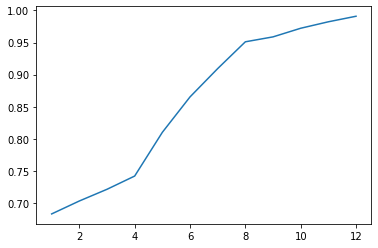

In [58]:
import matplotlib.pyplot as plt
yobi = [i for i in range(1, 13)]
plt.plot(yobi, ac_list)
plt.show()

高い精度を得るためには水曜日か木曜日までの情報が必要のようです・・・

In [0]:
def predict_type(dataframe, input_data):
    data_number = len(input_data[0])
    X = dataframe.iloc[:, :data_number]
    y = dataframe.iloc[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    accurary = clf.score(X_test, y_test)
    kabu_type = clf.predict(input_data)
    return accurary, show_type[kabu_type[0]]

実際の値で予想してみましょう！今週の私の村の株価を入力値としてみます

In [0]:
input_data = [[98, 144, 178]]
type_accuracy, type_name = predict_type(df, input_data)

In [54]:
print(type_accuracy, type_name)

0.7214765100671141 {3: '跳ね大型'}


大正解！・・・このあとなんと613ベルと高騰しました